# 1. 디렉토리 설정 및 라이브러리, 데이터 불러오기

python.version : 3.7.6 <br>
numpy.version : 1.18.1 <br>
pandas.version : 1.0.1 <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import *
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import pickle
import joblib

data = pd.read_csv('train.csv')

# 2. EDA

### a. class 비율 확인

In [2]:
data['class'].value_counts()

neg    39333
pos      667
Name: class, dtype: int64

### b. 각 알파벳으로 시작하는 변수 개수 확인

In [3]:
alph_count = pd.DataFrame(columns=['count'], index = ['a', 'b', 'c', 'd', 'e'])
a = 0
b = 0
c = 0
d = 0
e = 0

for i in range(data.shape[1]-1):
    if data.columns.drop('class')[i].find('a') == 0: #변수명이 'a'로 시작하는 변수 세기
        a += 1
    elif data.columns.drop('class')[i].find('b') == 0: #변수명이 'b'로 시작하는 변수 세기
        b += 1
    elif data.columns.drop('class')[i].find('c') == 0: #변수명이 'c'로 시작하는 변수 세기
        c += 1
    elif data.columns.drop('class')[i].find('d') == 0: #변수명이 'd'로 시작하는 변수 세기
        d += 1
    elif data.columns.drop('class')[i].find('e') == 0: #변수명이 'e'로 시작하는 변수 세기
        e += 1
    
    alph_count.iloc[0,0] = a
    alph_count.iloc[1,0] = b
    alph_count.iloc[2,0] = c
    alph_count.iloc[3,0] = d
    alph_count.iloc[4,0] = e

alph_count

,count
a,52
b,34
c,43
d,25
e,16


([<matplotlib.patches.Wedge at 0x1b160119088>,
 [Text(0.6300086213119431, 0.9017145540982605, 'a'),
  Text(-0.9132024842201182, 0.6132383083387771, 'b'),
  Text(-0.7410650960845749, -0.8129099109773235, 'c'),
  Text(0.544121622022538, -0.9559977303569096, 'd'),
  Text(1.0522649346220565, -0.3205284813629505, 'e')],
 [Text(0.3436410661701507, 0.49184430223541475, '30.6%'),
  Text(-0.4981104459382462, 0.334493622730242, '20.0%'),
  Text(-0.40421732513704084, -0.44340540598763095, '25.3%'),
  Text(0.29679361201229343, -0.5214533074674051, '14.7%'),
  Text(0.5739626916120307, -0.17483371710706389, '9.4%')])

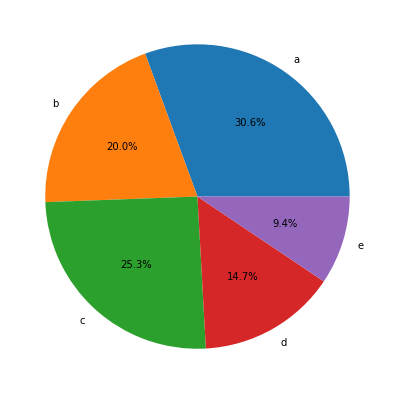

In [4]:
plt.figure(figsize=(7,7))
plt.pie(alph_count['count'], labels=alph_count.index.values, autopct='%.1f%%')

### c. 컬럼별 결측치 비율 확인 및 시각화

In [5]:
na = data.isna().sum().div(data.shape[0]).mul(100).to_frame().sort_values(by=0, ascending=False)
na.head()

,0
br_000,82.1175
bq_000,81.1950
bp_000,79.6125
ab_000,77.3475
cr_000,77.3475


In [6]:
na.tail()

,0
cj_000,0.52
ci_000,0.52
bt_000,0.27
aa_000,0.00
class,0.00


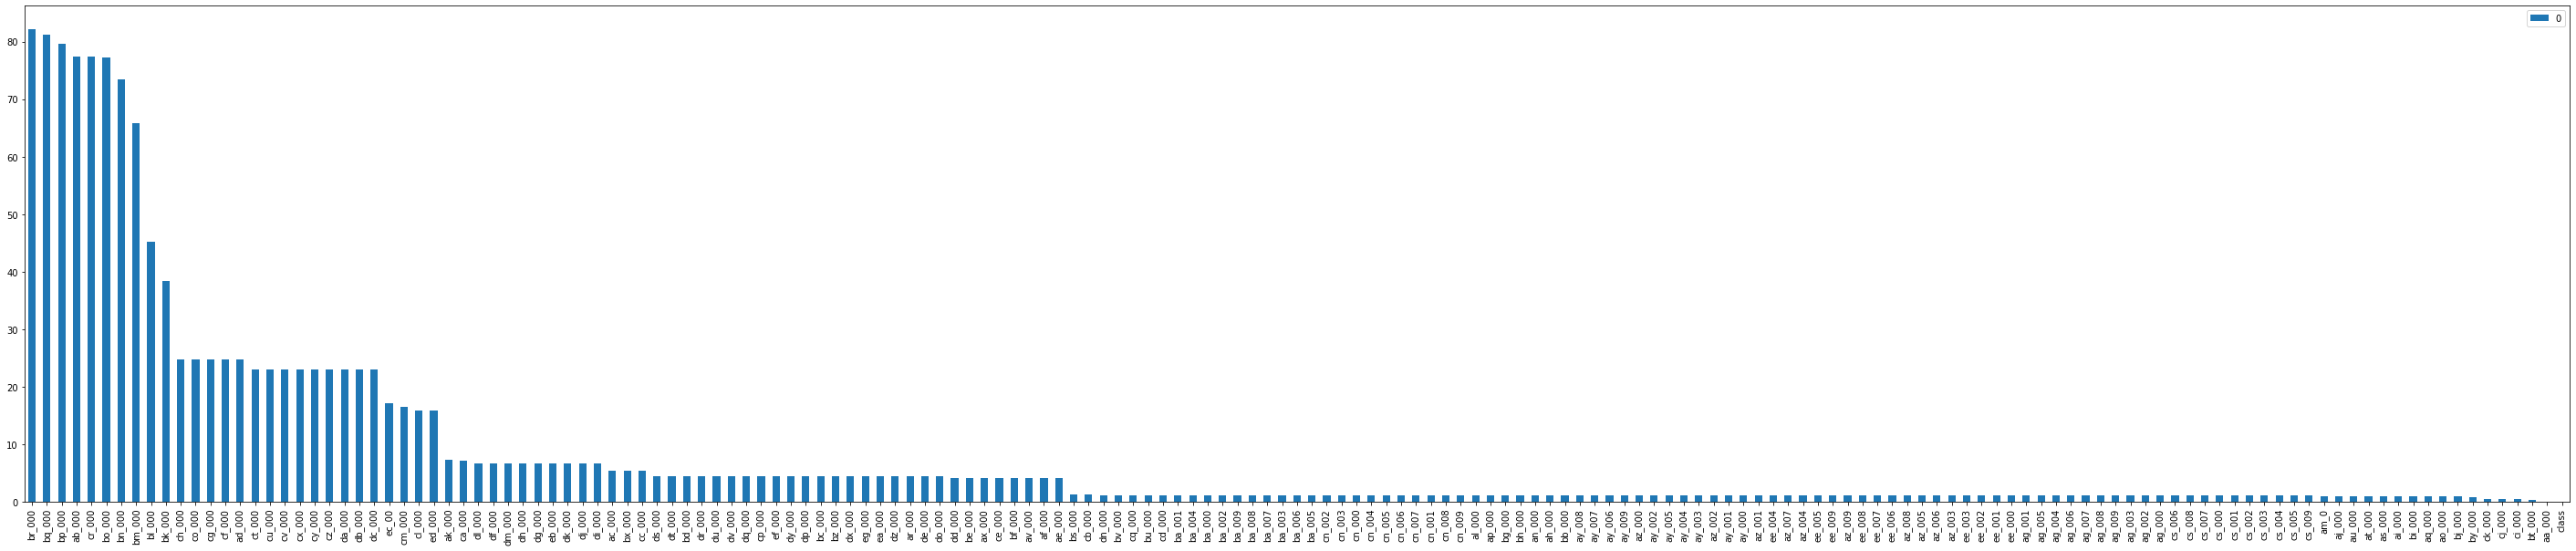

In [7]:
na.plot.bar(figsize=(50,10)) #시각화
plt.show()

# 3. 전처리

### a. 'class' 변수값 숫자형으로 변환

In [8]:
data["class"] = data["class"].astype("category").cat.codes #'pos'를 1로, 'neg'를 0으로 변환

### b. NA 비율이 높은 변수 제거

In [9]:
na.head(10) #column별 NA 비율을 내림차순으로 정렬했을 때 8위(65%)와 9위(45%) 간 간격이 상대적으로 넓음

,0
br_000,82.1175
bq_000,81.1950
bp_000,79.6125
ab_000,77.3475
cr_000,77.3475
bo_000,77.2300
bn_000,73.3850
bm_000,65.8650
bl_000,45.2875
bk_000,38.3650


In [10]:
#따라서 NA 비율이 65% 이상인 변수 제거
na_drop = list(na[na[0] >= 65].index) #NA 비율이 65% 이상인 변수들의 index
data = data.drop(na_drop, axis=1)

In [11]:
# test set 전처리를 위해 na_drop list 저장
with open( "na_drop_list", "wb" ) as file:
    pickle.dump( na_drop, file)

### c. 상관관계를 기준으로 변수 삭제

In [12]:
# 상관분석 결과 강한 상관관계를 보이는 변수 정제
cor = data.corr(method = 'pearson') #변수 163개(타겟변수 1개, 독립변수 162개)의 상관행렬

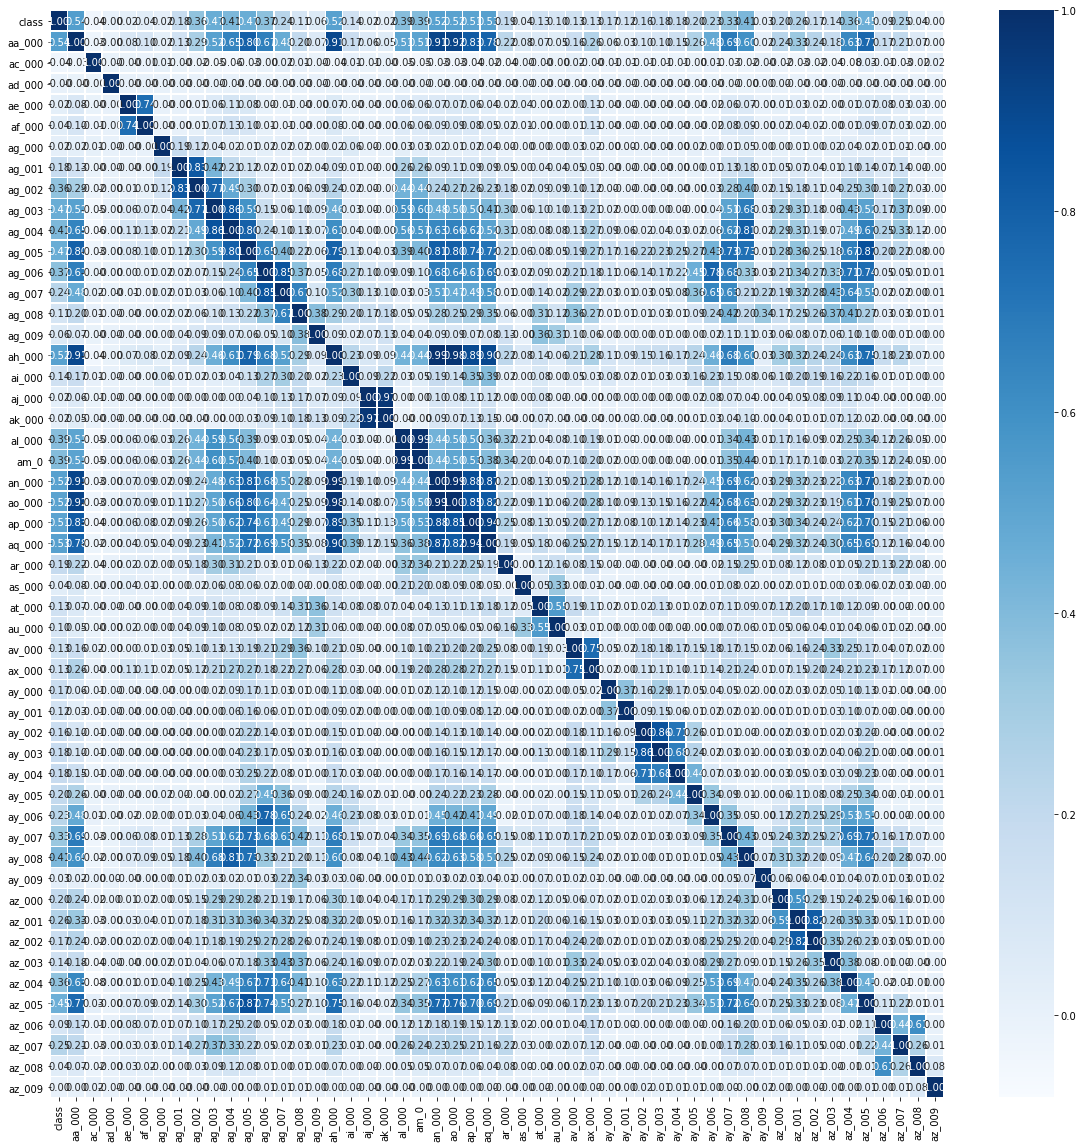

In [13]:
# 타겟변수 + 이름이 'a'로 시작하는 변수 51개의 corrplot
plt.figure(figsize=(20,20))
sns.heatmap(data = cor.iloc[0:52, 0:52], annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

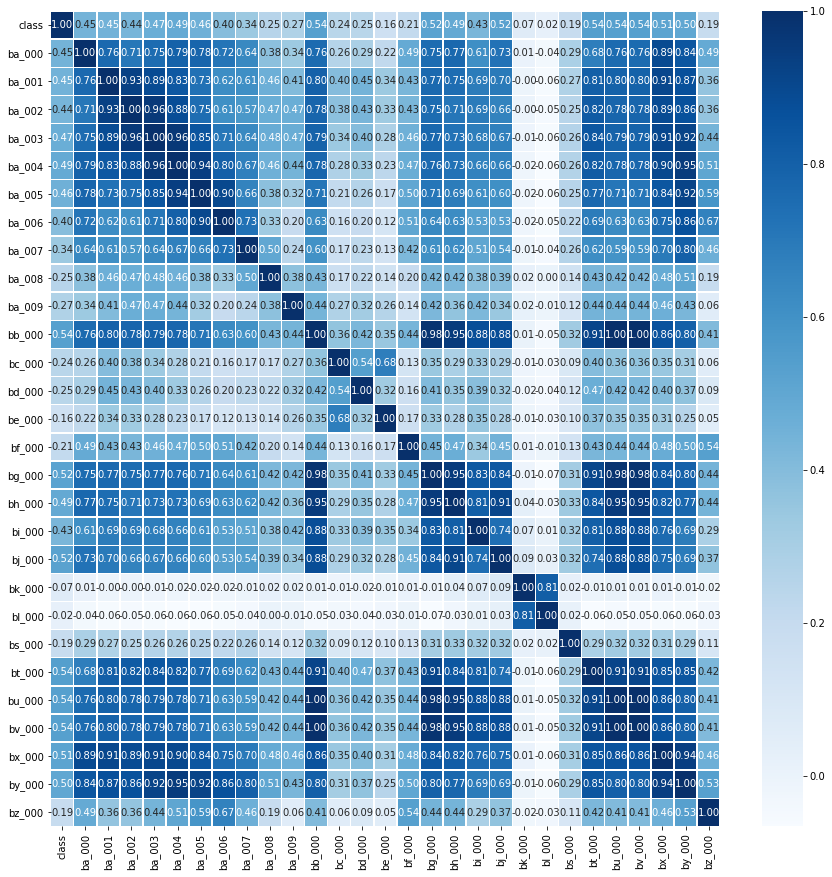

In [14]:
# 타겟변수 + 이름이 'b'로 시작하는 변수 28개의 corrplot
plt.figure(figsize=(15,15))
sns.heatmap(data = cor.iloc[np.r_[0,52:80], np.r_[0,52:80]], annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

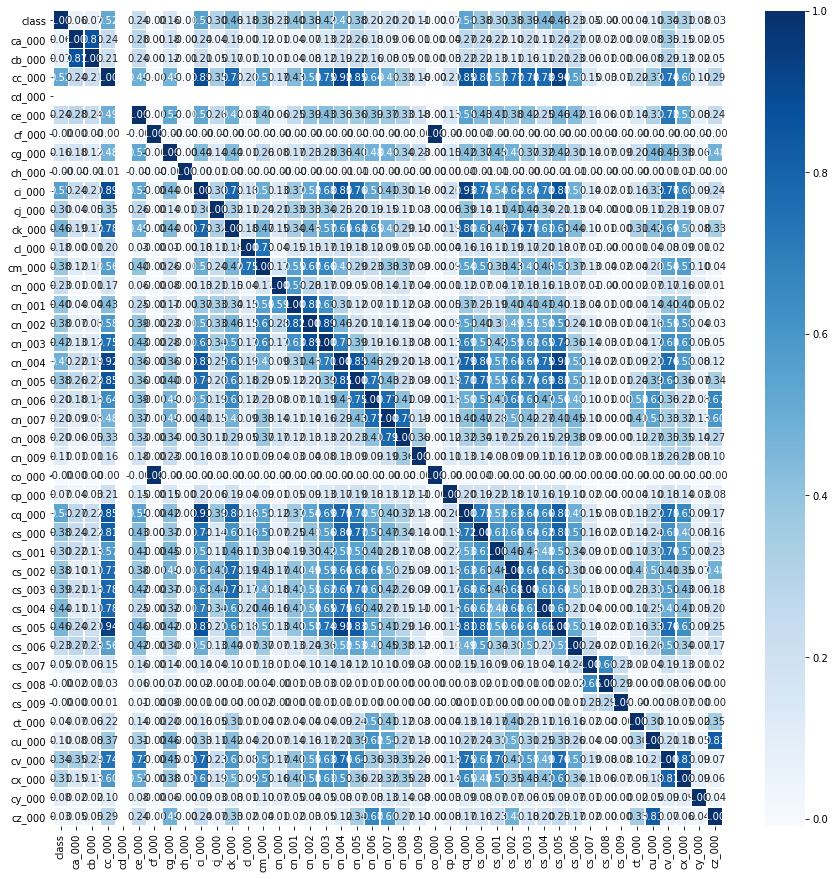

In [15]:
# 타겟변수 + 이름이 'c'로 시작하는 변수 42개의 corrplot
plt.figure(figsize=(15,15))
sns.heatmap(data = cor.iloc[np.r_[0,80:122], np.r_[0,80:122]], annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

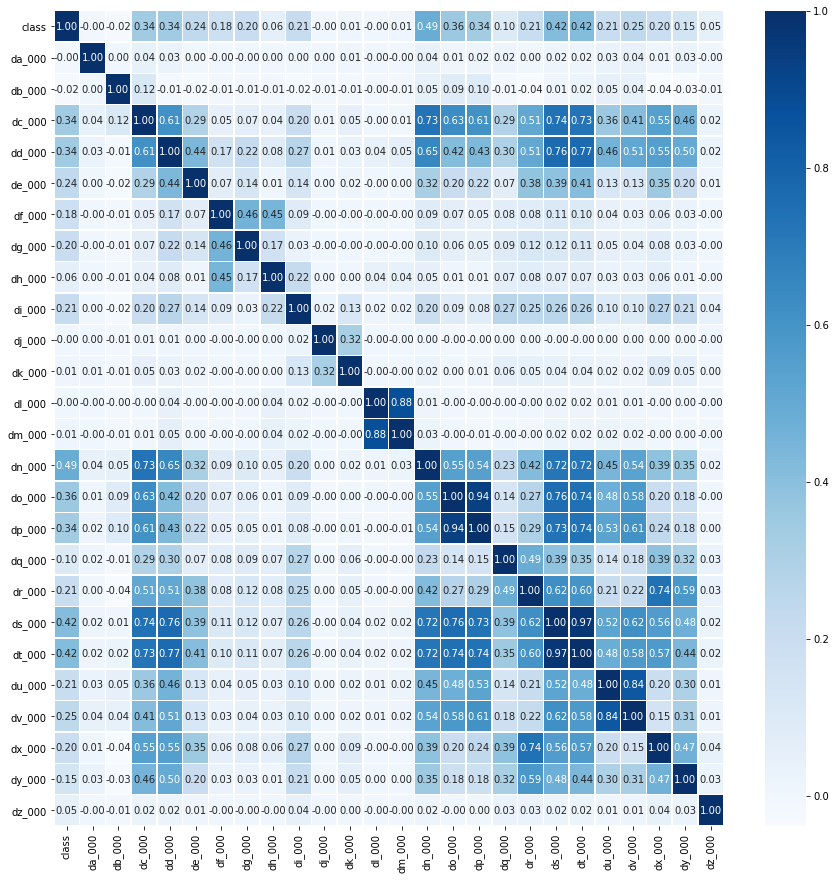

In [16]:
# 타겟변수 + 이름이 'd'로 시작하는 변수 25개의 corrplot
plt.figure(figsize=(15,15))
sns.heatmap(data = cor.iloc[np.r_[0,122:147], np.r_[0,122:147]], annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

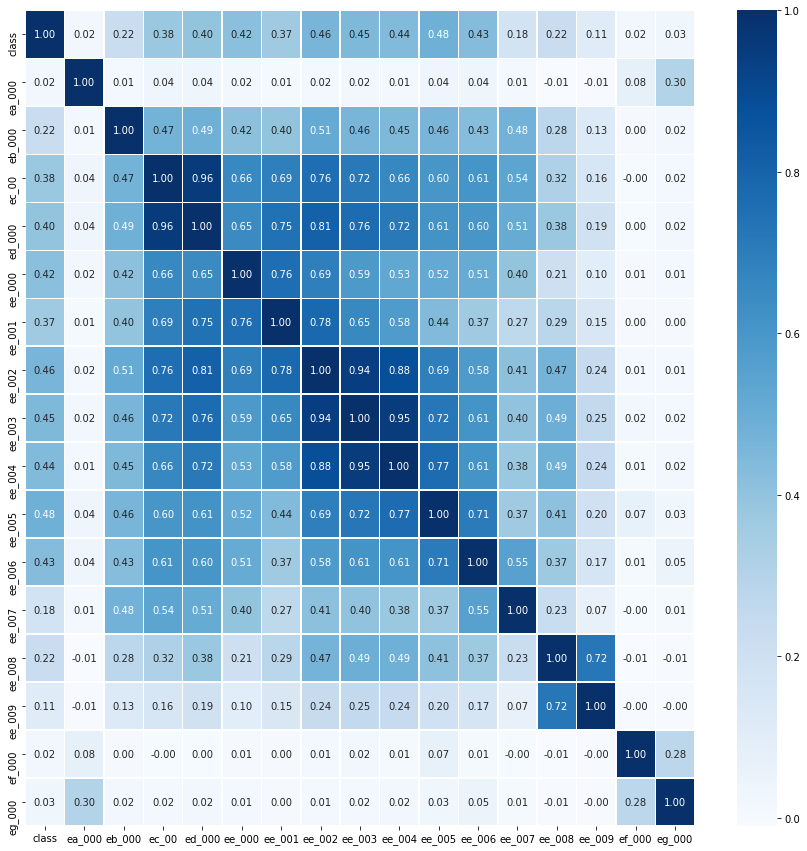

In [17]:
# 타겟변수 + 이름이 'e'로 시작하는 변수 16개의 corrplot
plt.figure(figsize=(15,15))
sns.heatmap(data = cor.iloc[np.r_[0,147:163], np.r_[0,147:163]], annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

In [18]:
# 상관계수가 높은 변수들이 매우 많지만, 변수의 의미를 알 수 없다는 한계 존재
# 중요 변수의 무차별적 제거를 방지하기 위해 상관계수가 0.9 이상 혹은 -0.9 이하인 변수들만을 정제
np.sum([cor <= -0.9]) #상관계수가 -0.9 이하인 경우는 전무해 0.9 이상인 것만 고려

163

In [19]:
def findCorrelation(df, thresh):
    corr = df.corr(method = 'pearson')
    col_drop = set() #제거 대상 변수명
    
    for i in range(len(corr.columns)):
        for j in range(i):
            if (corr.iloc[i,j] >= thresh) and (corr.columns[j] not in col_drop): #상관계수가 threshold(0.9) 이상이며 아직 제거 대상에 속해있지 않을 경우
                colname = corr.columns[i]
                col_drop.add(colname)
                if colname in df.columns:
                    del df[colname] #해당 column 삭제
    
    return df, col_drop

findCorrelation(data, 0.9) #column 개수 163개 -> 124개로 정제 

(       class  aa_000        ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
 0          0   41040  2.280000e+02   100.0     0.0     0.0     0.0     0.0   
 1          0      12  7.000000e+01    66.0     0.0    10.0     0.0     0.0   
 2          0   60874  1.368000e+03   458.0     0.0     0.0     0.0     0.0   
 3          0   38312  2.130706e+09   218.0     0.0     0.0     0.0     0.0   
 4          0      14  6.000000e+00     NaN     0.0     0.0     0.0     0.0   
 ...      ...     ...           ...     ...     ...     ...     ...     ...   
 39995      0      14  2.000000e+00     2.0     0.0     0.0     0.0     0.0   
 39996      0       0  0.000000e+00     0.0     0.0     0.0     0.0     0.0   
 39997      0      32  0.000000e+00     NaN     0.0     0.0     0.0     0.0   
 39998      0  153002  6.640000e+02   186.0     0.0     0.0     0.0     0.0   
 39999      0     112  2.130706e+09    18.0     0.0     0.0     0.0     0.0   
 
        ag_002  ag_003  ...    ec_00    ee_002    

In [20]:
# 상관관계로 삭제한 열 이름 저장
col_drop = ['ah_000','ak_000','am_0','an_000','ao_000','aq_000','ba_001','ba_003','ba_005','bb_000','bg_000','bh_000','bi_000','bj_000','bt_000','bu_000','bv_000','bx_000','by_000','cc_000','cf_000','ci_000','cn_001','cn_002','cn_003','cn_004','cn_005',
  'co_000','cq_000','cs_005','ct_000','dc_000','dn_000','dp_000','dt_000','ed_000','ee_000','ee_001','ee_003']

In [21]:
# test set 전처리를 위해 col_drop list 저장
with open( "col_drop_list", "wb" ) as file:
    pickle.dump( col_drop, file)

### d. 결측치 처리: MICE

In [22]:
# 매우 많은 변수들에서 missing이 발생한 데이터셋의 현 상황을 고려해 MICE 선택
columns = data.columns

imputer = IterativeImputer(random_state=26)
mice = imputer.fit(data)

data = pd.DataFrame(mice.transform(data))
data.columns = columns #column명 변경

data.isnull().values.any() #MICE 후 결측치 유무 확인

C:\Users\seses\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


False

### e. 클래스 불균형 처리 : SMOTE

<BarContainer object of 2 artists>

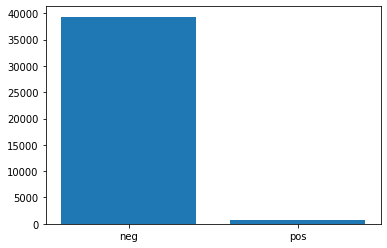

In [23]:
# over-sampling 전 데이터의 분포 비교
plt.bar(np.arange(2), data['class'].value_counts(), tick_label = ['neg','pos']) 

In [24]:
y = data['class']
x = data.drop('class', axis = 1)

smote = SMOTE(random_state = 26).fit_sample(x, y) #SMOTE를 이용한 over-sampling

<BarContainer object of 2 artists>

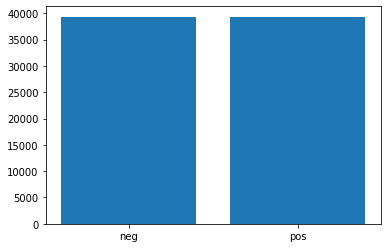

In [25]:
resample_x = pd.DataFrame(smote[0]) #over-sampling된 x를 데이터프레임 형태로 변환
resample_y = pd.DataFrame(smote[1]) #over-sampling된 y를 데이터프레임 형태로 변환
resample_y.columns = ['class']
data = pd.concat([resample_x, resample_y], axis = 1) #하나의 데이터프레임으로 합치기

# over-sampling 후 데이터의 분포 비교
plt.bar(np.arange(2), data['class'].value_counts(), tick_label = ['neg','pos'])

### f. 차원 축소 : 분산을 이용한 변수 선택, PCA

#### (1) 분산이 0인 변수 삭제

In [26]:
# 분산이 0인 변수 : 모든 관찰값이 같은 값을 가지므로 무의미
y = data['class']
x = data.drop('class', axis = 1)

thresholder = VarianceThreshold(threshold = 0) #기준값 만들기
var_drop = thresholder.fit(x) #기준값보다 높은 특성 선택

# test set 전처리를 위한 모델 저장
joblib.dump(var_drop, 'var_drop.pkl')

x = thresholder.transform(x)
x = pd.DataFrame(x)

x.shape #1개의 변수 삭제 확인

(78666, 122)

#### (2) PCA

In [27]:
# 표준화
scale = StandardScaler().fit(x) #특성 행렬 표준화 처리

# test set 전처리를 위한 모델 저장
joblib.dump(scale, 'standard.pkl')

scaled_x = scale.transform(x)

# PCA
pca = PCA(n_components=0.95) #95%의 분산 설명을 목표로 차원 축소
PCA = pca.fit(scaled_x)

# test set 전처리를 위한 모델 저장
joblib.dump(PCA, 'pca.pkl')

features_pca = PCA.transform(scaled_x)

# 결과 확인
print("원본 특성 개수:", scaled_x.shape[1])
print("줄어든 특성 개수:", features_pca.shape[1])

원본 특성 개수: 122
줄어든 특성 개수: 54


([<matplotlib.axis.XTick at 0x1b1682cc848>,
 <a list of 54 Text xticklabel objects>)

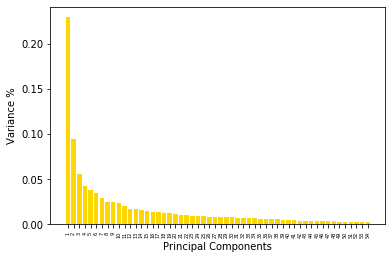

In [28]:
# 각 PC가 설명하는 분산 시각화
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC, rotation = 90, fontsize = 5)

In [29]:
pca.explained_variance_ #각 PC가 설명하는 분산

array([28.01419428, 11.51792279,  6.84718851,  5.21004852,  4.71621776,
        4.24227942,  3.61299884,  3.08096168,  2.98555261,  2.95293221,
        2.52810084,  2.1254776 ,  2.0333648 ,  1.89405019,  1.85820551,
        1.70204336,  1.64094722,  1.54537872,  1.49182494,  1.42732704,
        1.2928615 ,  1.24694001,  1.20572789,  1.17238001,  1.11571763,
        1.02876961,  1.01190675,  0.98698584,  0.96994007,  0.95269072,
        0.90580024,  0.87039564,  0.84644358,  0.81078834,  0.7744339 ,
        0.76361057,  0.7202011 ,  0.69996989,  0.65122592,  0.61318565,
        0.55239963,  0.52758308,  0.50397061,  0.48280674,  0.46681364,
        0.45395538,  0.42606916,  0.41388884,  0.38750542,  0.38043527,
        0.35354837,  0.33533994,  0.32477602,  0.3014736 ])

In [30]:
data = pd.DataFrame(data = features_pca) #PCA 결과를 데이터프레임 형태로 변환
data = pd.concat([data, y], axis=1)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,class
0,-4.011273,-0.216323,-0.047496,0.406680,-0.086997,-0.250830,0.055300,-0.232877,0.016184,0.065384,...,0.002072,0.055703,-0.014455,-0.092326,-0.025560,-0.053496,0.012567,-0.022459,0.037999,0.0
1,-4.534322,-0.085390,-0.011847,0.472210,-0.097672,-0.167005,0.411068,-0.541683,-0.086847,0.268292,...,0.295878,0.011860,-0.151916,-0.053702,-0.076413,0.032967,0.019346,0.140239,0.162733,0.0
2,-3.459014,-0.255168,0.004709,0.220031,-0.069873,0.031573,-0.132340,0.042255,0.003130,-0.053646,...,-0.129926,-0.004333,-0.014172,0.066850,0.123681,0.017371,-0.048930,0.043712,0.093805,0.0
3,-3.793304,-0.188702,0.024341,0.728019,-0.187500,-0.325836,0.015008,-0.473626,-0.012716,0.218209,...,0.302249,-0.202396,-0.102394,0.396707,0.096167,0.221250,0.033075,-0.165289,0.026181,0.0
4,-4.535518,-0.130828,-0.017086,0.501693,-0.161800,-0.350923,0.146444,-0.337775,-0.056102,0.124203,...,0.039266,-0.009985,-0.051987,-0.023182,-0.043704,0.041060,-0.041201,-0.001892,0.075492,0.0


# 4. 전처리 데이터 저장

In [31]:
data.to_csv('train_preprocessed.csv', header = True, index = False)